In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import trange
from importlib import reload

import utils.policies as polc
import utils.experiment_utils as expt
import utils.misc_utils as mutil

reload(polc)
reload(expt)
reload(mutil);

## Simulation Parameters

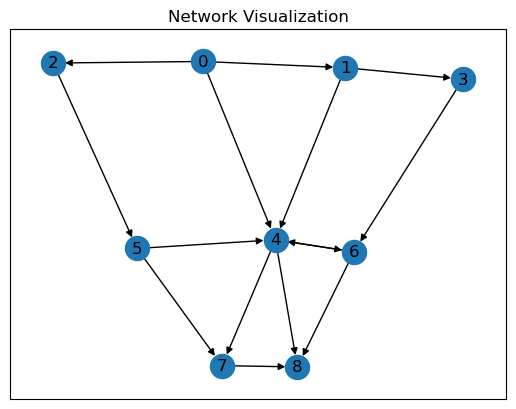

In [2]:
# simulation lengths
T_horizon = None # time horizon (to be set later)
T_horizon_list = 2000*np.arange(1,11)
N_runs = 10 # number of simulations

# noise and arrival rates
def random_uniform(size = []):
    return 2*np.random.uniform(size = size)-1
noise_distribution = random_uniform # np.random.standard_normal
noise_variance = 0.1 # sigma^2
arrival_rate   = 8  # lambda

# algorithm parameters
beta  = 5*noise_variance # exploration tuner (should theoretically be > 4 sigma^2)
nu    = None # backlog-cost tradeoff tuner (should theoretically be T^{1/3}) (to be set later)
delta = None # exploration tuner (should theoretically be T^{(-2 sigma^2)/(beta - 2 sigma^2)}) (to be set later)

# topology
N_nodes          = 9
source_node      = 0
destination_node = 8
edges_list       = [[0,1], [0,4], [0,2], [1,3], [1,4], [2,5], [3,6], [6,4], [4,6], [4,7], [5,4], [5,7], [6,8], [4,8], [7,8]]
node_edge_adjacency = mutil.prepare_adjacency(edges_list, N_nodes)

# edge properties
edge_capacities = np.array([4,2,2,2,2,2,2,1,1,1,1,1,2,5,2]) # max-flow = 8
true_edge_costs = np.array([2,5,1,1,2,1,1,1,1,1,1,3,3,1,1])/10

# pack parameters
simulation_params = mutil.SimulationParameters(node_edge_adjacency, 
                 true_edge_costs, edge_capacities, 
                 source_node, destination_node, 
                 noise_variance, noise_distribution,
                 arrival_rate, 
                 N_runs, T_horizon, 
                 beta, delta, nu)

# visualize topology
mutil.visualize_network(edges_list, N_nodes)

## Static Policy

In [3]:
# get solution to static optimization problem
stat_edge_rates = polc.get_static_policy(node_edge_adjacency, source_node, destination_node, true_edge_costs, edge_capacities, arrival_rate)
total_stat_cost_per_time = stat_edge_rates@true_edge_costs
stat_costs = T_horizon_list*total_stat_cost_per_time

## DPOP Policy

In [4]:
# intialization
tran_cost_till_T_dpop = np.zeros(T_horizon_list.shape)
backlog_cost_at_T_dpop = np.zeros(T_horizon_list.shape)

# iterate over given T values
for jj in trange(T_horizon_list.shape[0]):
    ii = T_horizon_list.shape[0] - jj - 1

    # change policy parameters for this value of T
    T_horizon_value             = T_horizon_list[ii]
    simulation_params.T_horizon = T_horizon_value
    simulation_params.nu        = T_horizon_value**(1/3)   
    simulation_params.delta     = 1 # T_horizon_value**(-2*noise_variance/(beta-2*noise_variance))

    # run experiment for this value of T
    queueing_network = expt.run_experiment(simulation_params, policy = 'dpop', custom_seed = 13)
    tran_cost_till_tt, backlog_cost_at_tt = expt.calculate_total_costs(queueing_network)
    
    # save cost and backlog values
    tran_cost_till_T_dpop[ii] = tran_cost_till_tt[-1]
    backlog_cost_at_T_dpop[ii] = backlog_cost_at_tt[-1]

# calculate total cost
dpop_costs = tran_cost_till_T_dpop + backlog_cost_at_T_dpop

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [03:34<00:00, 21.48s/it]


## Results Summary

Arrival rate = 8, noise variance = 0.1
True costs = [0.2 0.5 0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1 0.3 0.3 0.1 0.1]
Observed cost mean = [0.20527372 0.50569615 0.09483132 0.0984454  0.19958736 0.09770651
 0.10050259 0.10417211 0.10276357 0.0997807  0.09445892 0.30213112
 0.30384581 0.09529801 0.09242539]
Coefficients 1, sqrt(T)log(T), T^{2/3} = [1.00000000e+02 8.58152406e+01 4.35939894e-21]


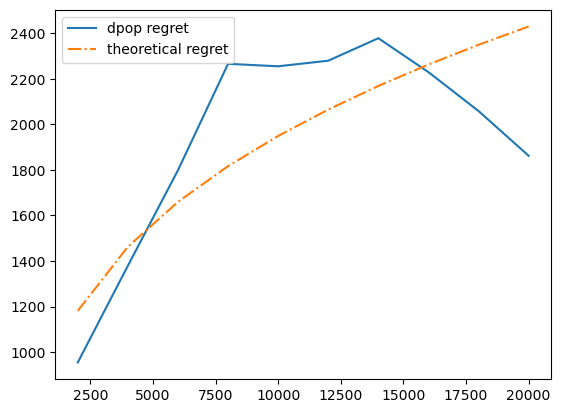

In [5]:
# save results
save_result = np.vstack((T_horizon_list, dpop_costs, stat_costs))
save_file = 'regret_results-lambda-' + str(arrival_rate).replace('.','_') + '-var-' + str(noise_variance).replace('.','_')
np.save('./results/' + save_file, save_result)

# retrive oracle (or no-noise) results
# oracle_results = np.load('./results/regret_results-lambda-' + str(arrival_rate).replace('.','_') + '-var-0.npy')

# get theoretical fit
dpop_regret = dpop_costs - stat_costs
theoretical_dpop_regret, curve_coefficients = mutil.fit_regret_curve(T_horizon_list, dpop_regret)

# print summary
print('Arrival rate = ' + str(arrival_rate) + ', noise variance = ' + str(noise_variance))
print('True costs = ' + str(true_edge_costs))
print('Observed cost mean = ' + str(queueing_network.edge_cost_means[0,:]))
print('Coefficients 1, sqrt(T)log(T), T^{2/3} = ' + str(curve_coefficients))

# plot regret
plt.plot(T_horizon_list, dpop_costs - stat_costs, label = 'dpop regret')
# plt.plot(oracle_results[0,:], oracle_results[1,:] - oracle_results[2,:], label = 'oracle regret')
plt.plot(T_horizon_list, theoretical_dpop_regret, '-.', label = 'theoretical regret')
plt.legend()
plt.show()